# Introduction to climlab and 1D grey radiation models

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import climlab

# Validate climlab against analytical solution for 2-layer atmosphere

In [2]:
#  Test in a 2-layer atmosphere
col = climlab.GreyRadiationModel(num_lev=2)
print col

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (2,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [3]:
col.subprocess

{'LW': <climlab.radiation.radiation.Radiation at 0x10edbf3d0>,
 'SW': <climlab.radiation.radiation.RadiationSW at 0x10edbf410>,
 'insolation': <climlab.radiation.insolation.FixedInsolation at 0x10edbf490>,
 'surface': <climlab.surface.surface_radiation.SurfaceRadiation at 0x10edbf510>}

In [4]:
col.state

{'Tatm': Field([ 278.,  200.]), 'Ts': Field([ 288.])}

In [5]:
col.Ts

Field([ 288.])

In [6]:
col.Ts[:] = 288.
col.Tatm[:] = np.array([275., 230.])
col.state

{'Tatm': Field([ 275.,  230.]), 'Ts': Field([ 288.])}

In [7]:
LW = col.subprocess['LW']
print LW

climlab Process of type <class 'climlab.radiation.radiation.Radiation'>. 
State variables and domain shapes: 
  Tatm: (2,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.radiation.radiation.Radiation'>



In [8]:
LW.absorptivity

Field([ 0.47737425,  0.47737425])

In [9]:
LW.absorptivity = 0.58377
LW.absorptivity

Field([ 0.58377,  0.58377])

In [10]:
col.diagnostics

{}

In [11]:
col.compute_diagnostics()
col.diagnostics

{'ASR': Field([ 239.2513]),
 'LW_absorbed_atm': array([-96.82138041,  20.03935568]),
 'LW_absorbed_sfc': Field([-162.23386935]),
 'LW_down_sfc': array([ 227.87116061]),
 'LW_emission': Field([ 189.31461699,   92.63278385]),
 'LW_up_sfc': Field([ 390.10502995]),
 'OLR': array([ 239.01589408]),
 'SW_absorbed_atm': array([-0., -0.]),
 'SW_absorbed_sfc': Field([ 239.2513]),
 'SW_absorbed_total': 239.25130000000001,
 'SW_down_TOA': Field([ 341.3]),
 'SW_down_sfc': array([ 341.3]),
 'SW_emission': Field([ 0.,  0.]),
 'SW_up_TOA': array([ 102.0487]),
 'SW_up_sfc': Field([ 0.]),
 'insolation': Field([ 341.3]),
 'planetary_albedo': Field([ 0.299])}

In [12]:
col.diagnostics['OLR']

array([ 239.01589408])

In [13]:
col.state

{'Tatm': Field([ 275.,  230.]), 'Ts': Field([ 288.])}

In [14]:
col.step_forward()

In [15]:
col.state

{'Tatm': Field([ 273.36692033,  230.33800245]), 'Ts': Field([ 289.59144429])}

In [16]:
# integrate out to radiative equilibrium
col.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 2.00962539378 years.


In [17]:
col.diagnostics['ASR'] - col.diagnostics['OLR']

Field([ -5.20579960e-07])

In [18]:
#  Compare these temperatures against our analytical solutions for radiative equilibrium
col.state

{'Tatm': Field([ 262.08988341,  233.62925798]), 'Ts': Field([ 296.20384538])}

# Get observed annual, global mean temperature profile

In [19]:
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = nc.Dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc" )
level = ncep_air.variables['level'][:]
lat = ncep_air.variables['lat'][:]
zstar = np.log(level/1000)

In [20]:
Tzon = np.mean(ncep_air.variables['air'][:],axis=(0,3))
Tglobal = np.average( Tzon , weights=np.cos(np.deg2rad(lat)), axis=1) + climlab.constants.tempCtoK

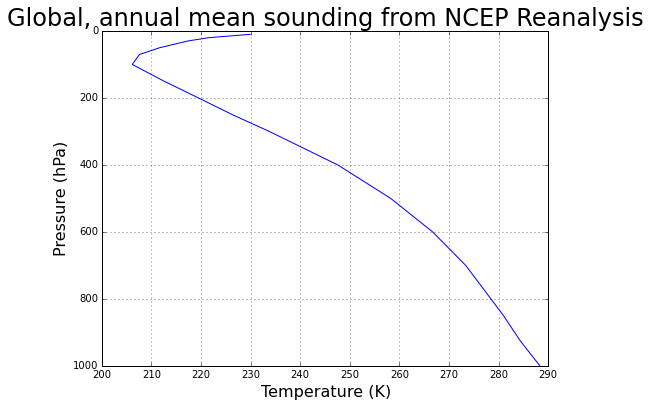

In [21]:
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(111)
ax.plot( Tglobal , level )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Global, annual mean sounding from NCEP Reanalysis', fontsize = 24)
ax.grid()

# Create 30-layer model with observed temperatures

In [22]:
#  initialize a grey radiation model with 30 levels
col = climlab.GreyRadiationModel()
print col

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [23]:
# interpolate to 30 evenly spaced pressure levels
lev = col.lev

In [24]:
Tinterp = np.flipud(np.interp(np.flipud(lev), np.flipud(level), np.flipud(Tglobal)))
Tinterp

array([ 287.4463874 ,  285.6810201 ,  283.98269653,  282.48550415,
        280.98831177,  279.29533895,  277.60236613,  275.90939331,
        274.21642049,  272.25855509,  270.03579712,  267.81303914,
        265.29490662,  262.48139954,  259.66789246,  256.48087056,
        252.92033386,  249.35979716,  245.279658  ,  240.67991638,
        236.08017476,  231.30422974,  226.3520813 ,  221.78253174,
        217.19399007,  212.5864563 ,  208.29145304,  206.96234809,
        211.6633606 ,  224.34736125])

In [25]:
# Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp

In [26]:
def plot_sounding(collist):
    color_cycle=['r', 'g', 'b', 'y']
    # col is either a column model object or a list of column model objects
    if isinstance(collist, climlab.Process):
        # make a list with a single item
        collist = [collist]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, col in enumerate(collist):
        ax.plot(col.Tatm, col.lev, color=color_cycle[i])
        ax.plot(col.Ts, climlab.constants.ps, 'o', markersize=12, color=color_cycle[i])
    ax.invert_yaxis()
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (hPa)')
    ax.grid()
    return ax

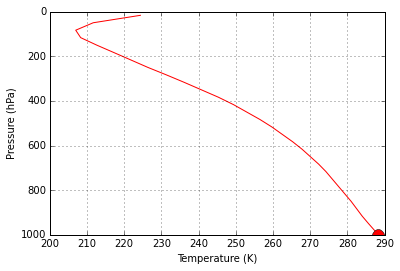

In [27]:
plot_sounding(col)

# Tune absorptivity to get observed OLR

In [28]:
col.compute_diagnostics()
col.diagnostics['OLR']

array([ 263.15000847])

In [29]:
# Need to tune absorptivity to get OLR = 239
epsarray = np.linspace(0.01, 0.1, 100)
OLRarray = np.zeros_like(epsarray)

In [30]:
for i in range(epsarray.size):
    col.subprocess['LW'].absorptivity = epsarray[i]
    col.compute_diagnostics()
    OLRarray[i] = col.diagnostics['OLR']

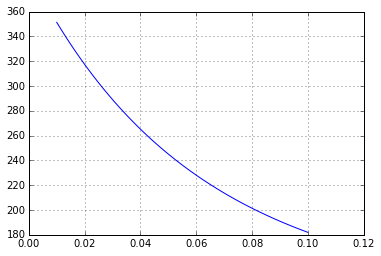

In [31]:
plt.plot(epsarray, OLRarray)
plt.grid()

In [32]:
def OLRanom(eps):
    col.subprocess['LW'].absorptivity = eps
    col.compute_diagnostics()
    return col.diagnostics['OLR'] - 239.

In [33]:
OLRanom(0.02)

array([ 78.43160775])

In [34]:
# Use numerical root-finding to get the equilibria
from scipy.optimize import brentq
# brentq is a root-finding function
#  Need to give it a function and two end-points
#  It will look for a zero of the function between those end-points
eps = brentq(OLRanom, 0.01, 0.1)
print eps

0.0534031861637


In [35]:
col.subprocess['LW'].absorptivity = eps
col.subprocess['LW'].absorptivity

Field([ 0.05340319,  0.05340319,  0.05340319,  0.05340319,  0.05340319,
        0.05340319,  0.05340319,  0.05340319,  0.05340319,  0.05340319,
        0.05340319,  0.05340319,  0.05340319,  0.05340319,  0.05340319,
        0.05340319,  0.05340319,  0.05340319,  0.05340319,  0.05340319,
        0.05340319,  0.05340319,  0.05340319,  0.05340319,  0.05340319,
        0.05340319,  0.05340319,  0.05340319,  0.05340319,  0.05340319])

In [36]:
col.compute_diagnostics()
col.diagnostics['OLR']

array([ 239.])

# Compute radiative forcing for a 2% increase in absorptivity

In [37]:
col2 = climlab.process_like(col)
print col2

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [38]:
col2.subprocess['LW'].absorptivity *= 1.02
col2.subprocess['LW'].absorptivity

Field([ 0.05447125,  0.05447125,  0.05447125,  0.05447125,  0.05447125,
        0.05447125,  0.05447125,  0.05447125,  0.05447125,  0.05447125,
        0.05447125,  0.05447125,  0.05447125,  0.05447125,  0.05447125,
        0.05447125,  0.05447125,  0.05447125,  0.05447125,  0.05447125,
        0.05447125,  0.05447125,  0.05447125,  0.05447125,  0.05447125,
        0.05447125,  0.05447125,  0.05447125,  0.05447125,  0.05447125])

In [39]:
col2.compute_diagnostics()
col2.diagnostics['OLR']

array([ 237.15483205])

In [40]:
col2.Ts - col.Ts

Field([ 0.])

In [41]:
col2.diagnostics['OLR'] - col.diagnostics['OLR']

array([-1.84516795])

In [42]:
RF = -(col2.diagnostics['OLR'] - col.diagnostics['OLR'])
print 'The radiative forcing is %f W/m2.' %RF

The radiative forcing is 1.845168 W/m2.


# Radiative equilibrium in the 30-layer model

In [43]:
re = climlab.process_like(col)

In [44]:
re.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 2.91861126672 years.


In [45]:
#  Check for energy balance
re.diagnostics['ASR'] - re.diagnostics['OLR']

Field([ -8.67411302e-07])

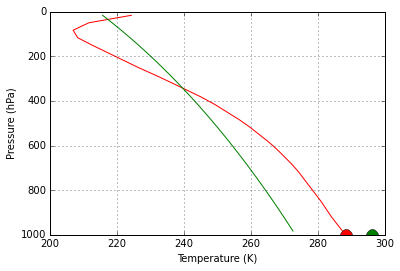

In [46]:
plot_sounding([col, re])

# Radiative-Convective equilibrium in the 30-layer model

In [47]:
rce = climlab.RadiativeConvectiveModel(adj_lapse_rate=6.)
print rce

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [48]:
rce.subprocess['LW'].absorptivity = eps

In [49]:
rce.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


In [50]:
#  Check for energy balance
rce.diagnostics['ASR'] - rce.diagnostics['OLR']

Field([  6.23502277e-06])

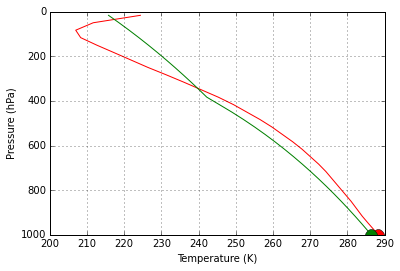

In [51]:
plot_sounding([col, rce])

# Greenhouse warming in RCE model

In [52]:
# ANother 1% increase in absorptivity
rce2 = climlab.process_like(rce)
rce2.subprocess['LW'].absorptivity *= 1.02

In [53]:
rce2.compute_diagnostics()
RF = -(rce2.diagnostics['OLR'] - rce.diagnostics['OLR'])
print 'The radiative forcing is %f W/m2.' %RF

The radiative forcing is 1.661031 W/m2.


In [54]:
#  Timestep forward, and the check for energy balance
rce2.integrate_years(2.)
rce2.diagnostics['ASR'] - rce2.diagnostics['OLR']

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 4.00556124128 years.


Field([  2.17204416e-07])

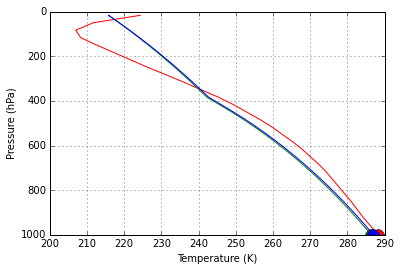

In [55]:
plot_sounding([col, rce, rce2])

In [56]:
ECS = rce2.Ts - rce.Ts
print 'Equilibrium climate sensitivity is %f K.' %ECS

Equilibrium climate sensitivity is 0.576941 K.


In [57]:
# Calculate the net climate feedback
#  This is the change in TOA flux per degree warming that was necessary to get back to equilibrium.
feedback = -RF/ECS
print 'The net feedback is %f W/m2/K' %feedback 

The net feedback is -2.879032 W/m2/K


In [58]:
#  could calculate a Planck feedback explicitly...
#   What would the TOA flux change be if the warming were perfectly uniform?
rce3 = climlab.process_like(rce)
rce3.subprocess['LW'].absorptivity *= 1.02
rce3.Ts += ECS
rce3.Tatm += ECS